In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/BRATS_Training.zip" -d "/content/sample_data/Dataset"  

Archive:  /content/drive/MyDrive/BRATS_Training.zip
   creating: /content/sample_data/Dataset/BRATS-2/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/
  inflating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/License_CC_BY_NC_SA_3.0.txt  
  inflating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.684.mha  
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_T1/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_T1c/
  inflating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_T1c/License_CC_BY_NC_SA_3.0.txt  
  inflating: /content/sample_data/Dataset/BRATS-2/Im

In [ ]:

!pip install nibabel pydicom medpy
!pip install nipype
!pip install patchify
# !pip install imgaug
!pip install imgaug 0.2.7
!pip install SimpleITK

     |████████████████████████████████| 1.9MB 9.2MB/s 
     |████████████████████████████████| 153kB 35.6MB/s 
     |████████████████████████████████| 47.4MB 67kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753422 sha256=5bbf6f11834ed98782e9ec3cf7a906f3031acbdfbbad58fe0b3f4fd81855035e
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy
     |████████████████████████████████| 3.2MB 7.8MB/s 
     |████████████████████████████████| 133kB 29.2MB/s 
     |████████████████████████████████| 430kB 48.2MB/s 
     |████████████████████████████████| 5.1MB 51.2MB/s 
     |████████████████████████████████| 235kB 41.3MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 12.4MB 257kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: sci

In [ ]:
import numpy as np 
from PIL import Image
from os import listdir
from os.path import isfile, join
from medpy.io import load, save
from patchify import patchify, unpatchify
import SimpleITK as sitk
from PIL import Image as im 
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

In [ ]:
NUMBER_OF_0_LALBEL = 310000

In [ ]:

def read_image(path = "/content/sample_data/Dataset/BRATS-2/Image_Data/HG"):
  all_samples_folders = [f for f in listdir(path)]
  all_sample_images = []
  s = 0
  for sample_folder in all_samples_folders:
    if s == 20:
      break
    s+=1
    sample_images = [0,0,0,0,0]
    folder_names = [f for f in listdir(path+"/"+sample_folder)]
    file_names = [f for fn in folder_names for f in listdir(path+"/"+sample_folder+"/"+fn) if ".mha" in f]
    for fn in folder_names:
      file_names = [f for f in listdir(path+"/"+sample_folder+"/"+fn) if ".mha" in f]
     
      image_data , _ = load(path+"/"+sample_folder+"/"+fn+"/"+file_names[0])
      if "T1c" in file_names[0]:
        sample_images[2] = image_data
      elif "T2" in file_names[0]:
        sample_images[1] = image_data
      elif "Flair" in file_names[0]:
        sample_images[3] = image_data
      elif "T1" in file_names[0]:
        sample_images[0] = image_data
      else:
        sample_images[4] = image_data

    
    all_sample_images.append(sample_images)

  print("number of all samples: ", len(all_sample_images))
  print("number of each sample imags: ", len(all_sample_images[0]))
  print("image shape: ", all_sample_images[0][0].shape)

  # plt.figure(figsize=(15, 12))
  # for i in range(5):
  #   plt.subplot(1,  5, i+1)
  #   plt.imshow(all_sample_images[0][i][:,:,100])

  return all_sample_images[:17],all_sample_images[17:] 

def merge_different_modality(images):
  
  all_new_sample = []
  no_tumor = 0
  for sample in images:
    new_sample = []
    for z in range(sample[0].shape[-1]):
      # un slide hayi ke tumor tush hast ro negah darim
      if np.sum(sample[4][:,:,z]) != 0:
        new_img = np.dstack((sample[0][:,:,z],sample[1][:,:,z],sample[2][:,:,z],sample[3][:,:,z],sample[4][:,:,z]))
        new_sample.append(np.array(new_img))
      else:
        no_tumor+=1
    all_new_sample.append(new_sample)

  print("no tumor: ", no_tumor)
  print("number of all samples: ",len(all_new_sample))
  print("number of each sample imags: ",len(all_new_sample[0]))
  print("image shape here: ",all_new_sample[0][0].shape)

 
  return all_new_sample
    
      

def creat_patch(images, patch_size = 33):
  l = (patch_size - 1) / 2
  patch_sample = []
  X_train = []
  y_train = []
  l = [0,0,0,0,0]
  for sample in images:
    patch_img = []
    for img in sample:
      patches = patchify(img, (33, 33, 5), step=1)
      # patches = patchify(img, (65, 65, 5), step=1)
      
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          
          y = patches[i,j,0,:,:,4]
          label = [0,0,0,0,0]
          label[y[16,16]] = 1
          l[y[16,16]]+=1
          if y[16,16] != 0 :
            y_train.append(np.array(label))
            X_train.append(patches[i,j,0,:,:,:4])
          else:
             if l[y[16,16]] <= NUMBER_OF_0_LALBEL:
                y_train.append(np.array(label))
                X_train.append(patches[i,j,0,:,:,:4])
         
  print("real number of each label: ", l)
  return X_train, y_train, l
  
def pre_process(images):
  print("start preprocess")
  print("..... waiting")
  
  for sample in images:
    for img in sample[:4]:
      for a in range(img.shape[-1]):
        
        b, t = np.percentile(img[:,:,a], (0.5,99.5))
        img[:,:,a] = np.clip(img[:,:,a], b, t)
        if np.std(img[:,:,a]) != 0:
            img[:,:,a] = (img[:,:,a] - np.mean(img[:,:,a])) / np.std(img[:,:,a])
        
  print("finish preprocess")  
  return images


images, test_images = read_image()
normalized_img = pre_process(images)
final_images = merge_different_modality(normalized_img)
X_train, y_train, label_num = creat_patch(final_images)
print(X_train[0].shape)
print("number of train sample: ", len(X_train))
print("number of train label: ", len(y_train))


number of all samples:  20
number of each sample imags:  5
image shape:  (176, 216, 176)
start preprocess
..... waiting
finish preprocess
no tumor:  2027
number of all samples:  17
number of each sample imags:  59
image shape here:  (176, 216, 5)
real number of each label:  [28826049, 230835, 1267767, 178309, 460672]
(33, 33, 4)
number of train sample:  2447583
number of train label:  2447583


In [ ]:
def number_of_each_label(y_train):
  l = [0,0,0,0,0]
  new_y = []
  for i in y_train:
    ll = list(i).index(1)
    l[ll]+=1
  print("label 1: for necrosis \n label 2: for edema \n label 3: for non-enhancing tumor \n label 4: for enhancing tumor \n label 0: for everything else")  
  print("Number of each class: ")
  for n, i in enumerate(l) :
    print("label ",n,": ", i)


def draw_patch(label):
  for i, j in zip(X_train, y_train):
    if j[label] == 1:
      plt.imshow(i[:,:,0], cmap = "gray")
      break


In [ ]:
number_of_each_label(y_train)
# draw_patch(4)


label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  310000
label  1 :  230835
label  2 :  1267767
label  3 :  178309
label  4 :  460672


In [ ]:
def agument_data(class_, X_train, y_train):
  data_augmentation1 = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])
  
  new_img = np.asarray(class_, dtype = "uint8")  
  aug_img = data_augmentation1(new_img)
  for i in aug_img:
    X_train.append(i)
    y_train.append([0,0,0,1,0])
  
  return X_train, y_train

def balance_data(X_train, y_train):

  X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

  X_train_new = [] 
  y_train_new = []
  class_3 = []
  class_1 = []
  x2 = 1
  x4 = 1
  x1 = 1
  for i,j in zip(X_train, y_train):

    if j[2] == 1 and x2 <= NUMBER_OF_0_LALBEL:
      X_train_new.append(i)
      y_train_new.append(j)
      x2+=1
    elif j[4] == 1 and x4 <= NUMBER_OF_0_LALBEL:
      X_train_new.append(i)
      y_train_new.append(j)
      x4+=1
    # elif j[1] == 1 and x1 <= NUMBER_OF_0_LALBEL:
    #   X_train_new.append(i)
    #   y_train_new.append(j)
    #   x1+=1
    
    elif j[0] == 1 or j[3] == 1 or j[1] == 1:
      if j[3] == 1:
        class_3.append(i)
      if j[1] == 1:
        class_1.append(i)
      X_train_new.append(i)
      y_train_new.append(j)

  data_augmentation1 = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])
  
  new_img = np.asarray(class_3, dtype = "uint8")  
  aug_img = data_augmentation1(new_img)
  for i in aug_img[:NUMBER_OF_0_LALBEL - 178309]:
    X_train_new.append(i)
    y_train_new.append([0,0,0,1,0])
  del new_img
  new_img = np.asarray(class_1, dtype = "uint8")  
  aug_img = data_augmentation1(new_img)
  for i in aug_img[:NUMBER_OF_0_LALBEL - 230835]:
    X_train_new.append(i)
    y_train_new.append([0,1,0,0,0])

  del new_img
  del X_train
  del y_train
  
  return X_train_new, y_train_new

def make_data_with_real_dist(X_train, y_train, label_num):
  l_max = max(label_num)
  label_num = [np.ceil((i/l_max)*NUMBER_OF_0_LALBEL) for i in label_num]
  print(label_num)
  X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

  X_train_new = [] 
  y_train_new = []
  count_ = [0,0,0,0,0]
  for i,j in zip(X_train, y_train):

    if j[1] == 1 and count_[1] <= label_num[1]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[1]+=1
    elif j[2] == 1 and count_[2] <= label_num[2]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[2]+=1
    if j[3] == 1 and count_[3] <= label_num[3]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[3]+=1
    if j[4] == 1 and count_[4] <= label_num[4]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[4]+=1
    elif j[0] == 1:
      X_train_new.append(i)
      y_train_new.append(j)
  del X_train
  del y_train
  
  return X_train_new, y_train_new


   
real_X, real_y = make_data_with_real_dist(X_train, y_train, label_num)
X_train, y_train = balance_data(X_train, y_train)

del balance_data
del make_data_with_real_dist
print("alanced data: ")
number_of_each_label(y_train)
print("Real data: ")
number_of_each_label(real_y)

[310000.0, 2483.0, 13634.0, 1918.0, 4955.0]
alanced data: 
label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  310000
label  1 :  310000
label  2 :  310000
label  3 :  310000
label  4 :  310000
Real data: 
label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  310000
label  1 :  2484
label  2 :  13635
label  3 :  1919
label  4 :  4956


In [ ]:
import keras
from keras import backend as K
from keras.layers import Input, Dropout, Flatten
from tensorflow.keras import regularizers
from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import time


In [ ]:
IMG_HEIGHT = 33
IMG_WIDTH = 33
IMG_CHANNELS = 4
BATCH_SIZE = 256
EPOCH = 10

In [ ]:
def two_pathway_model():

  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  # s = Lambda(lambda x: x / 255) (inputs)
 
  c1_0 = Conv2D(64, kernel_size = (7,7), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (inputs)
  p1 = MaxPooling2D((4,4),strides=(1,1), padding="valid") (c1_0)
  b1 = BatchNormalization()(p1)
  d1 = Dropout(0.5)(b1)

  c2_0 = Conv2D(64, kernel_size = (3,3), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (d1)
  p2 = MaxPooling2D((2,2),strides=(1,1), padding="valid") (c2_0)
  b2 = BatchNormalization()(p2)
  d2 = Dropout(0.5)(b2)
 
  
  c3_0 = Conv2D(160, kernel_size = (13,13), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (inputs)
  d3 = Dropout(0.5)(c3_0)
  
  final = tf.keras.layers.Concatenate(axis=-1)([d2, d3])

  outputs = Conv2D(5, (21, 21), activation='softmax') (final)
  final_out = Flatten()(outputs)
  
  model = keras.Model(inputs, final_out)
  return model


model_two_path = two_pathway_model()
model_two_path.summary()


def cascaded(mode, data):

    
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  if mode == 1:
    inputs = tf.keras.layers.Concatenate(axis=-1)([inputs, data])
  
  c1_0 = Conv2D(64, kernel_size = (7,7), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (inputs)
  p1 = MaxPooling2D((4,4),strides=(1,1), padding="valid") (c1_0)
  d1 = Dropout(0.5)(p1)
 
  if mode == 2:
    p1 = tf.keras.layers.Concatenate(axis=-1)([d1, data])

  c2_0 = Conv2D(64, kernel_size = (3,3), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (d1)
  p2 = MaxPooling2D((2,2),strides=(1,1), padding="valid") (c2_0)
  d2 = Dropout(0.5)(p2)
 
  
  c3_0 = Conv2D(160, kernel_size = (13,13), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (inputs)
  d3 = Dropout(0.5)(c3_0)
  
  
  final = tf.keras.layers.Concatenate(axis=-1)([d2, d3])
  if mode == 3:
    final = tf.keras.layers.Concatenate(axis=-1)([final, data])

  outputs = Conv2D(5, (21, 21), activation='softmax') (final)
  final_out = Flatten()(outputs)
  
  model = keras.Model(inputs, final_out)

  model = keras.Model(inputs, outputs)
  return model




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33, 33, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 27, 27, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,  labels, X_train, batch_size=256, dim=(33,33), n_channels=4,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=list)
        # print(X.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = X_train[int(ID)]
            # print(x.shape)
            # X[i,] = load('/content/sample_data/patch_data1/img/patch_' + ID + '.jpg')

            # Store class
            # print(self.labels[ID])
            y[i] = list(self.labels[ID]).index(1)

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
labels = {}
id = []
for i in range(len(X_train)):
  id.append(str(i))
  labels[str(i)] = y_train[i]
print(len(labels))
print(len(id))

1550000
1550000


In [ ]:
# to run twopathway only

training_generator = DataGenerator(id, labels, X_train)

sgd = keras.optimizers.SGD(lr=0.005, decay=0.01, momentum=0.9)
model_two_path.compile(optimizer=sgd, loss= "categorical_crossentropy", metrics=['accuracy'])
t1 = time.time()
history = model_two_path.fit(training_generator, epochs= 10,batch_size = BATCH_SIZE, verbose = 1)
t2 = time.time()
print("training time: ", t2 -t1)
metric = history.history['accuracy']



Epoch 1/10
6054/6054 [==============================] - 359s 58ms/step - loss: 2.3843 - accuracy: 0.7293
Epoch 2/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.6003 - accuracy: 0.8029
Epoch 3/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.5653 - accuracy: 0.8136
Epoch 4/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.5471 - accuracy: 0.8203
Epoch 5/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.5313 - accuracy: 0.8253
Epoch 6/10
6054/6054 [==============================] - 352s 58ms/step - loss: 0.5242 - accuracy: 0.8286
Epoch 7/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.5203 - accuracy: 0.8293
Epoch 8/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.5168 - accuracy: 0.8300
Epoch 9/10
6054/6054 [==============================] - 353s 58ms/step - loss: 0.5075 - accuracy: 0.8327
Epoch 10/10
6054/6054 [==============================] 

Text(0.5, 1.0, 'Train loss')

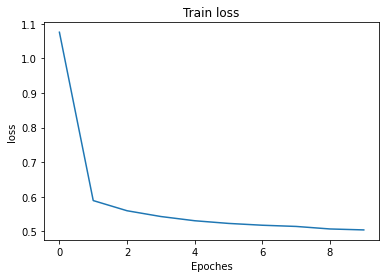

In [ ]:
l = history.history['loss']
plt.plot([i for i in range(10)],l)
plt.xlabel("Epoches")
plt.ylabel("loss") 
plt.title("Train loss")

In [ ]:
for layer in model_two_path.layers[:-2]:
    layer.trainable = False
 
for layer in model_two_path.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fcc7708beb8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcc7708be80> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcc77098550> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcc760a5128> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fcc76778940> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fcc7603ef60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fcc5015ae80> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fcc5018df60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc9f096add8> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fc9f09707b8> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fc9f096a3c8> False
<tensorflow.python.keras.layers.merge.Concatenate object 

In [ ]:
real_X = np.asarray(real_X, dtype = "uint8")
real_y = np.asarray(real_y, dtype = "uint8")

In [ ]:
model_two_path.fit(real_X, real_y, epochs= 1,batch_size = 128, verbose = 1)

2602/2602 [==============================] - 75s 29ms/step - loss: 0.1263 - accuracy: 0.9809


In [ ]:
 #test
normalized_img_test = pre_process(test_images)
final_images_test = merge_different_modality(normalized_img_test)
print(len(final_images_test))
X_test, y_test, label_num = creat_patch([final_images_test[0]])
print("number of train sample: ", len(X_test))
print("number of train label: ", len(y_test))

n = number_of_each_label(y_test)
print("number of each label:", n)

start preprocess
..... waiting
finish preprocess
no tumor:  335
number of all samples:  3
number of each sample imags:  84
image shape here:  (176, 216, 5)
3
real number of each label:  [2051737, 1249, 148276, 3147, 21255]
number of train sample:  483927
number of train label:  483927
label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  310000
label  1 :  1249
label  2 :  148276
label  3 :  3147
label  4 :  21255
number of each label: None


In [ ]:
X_test = np.asarray(X_test, dtype = "uint8")
y_test = np.asarray(y_test, dtype = "uint8")

In [ ]:
p = model_two_path.predict(X_test)

In [ ]:
all = [0,0,0,0,0]
pred = [0,0,0,0,0]
crr = [0,0,0,0,0]
for i,j in zip(p,y_test):
  all[list(j).index(1)]+=1
  pred[np.argmax(i)]+=1
  if list(j).index(1) == np.argmax(i):
    crr[np.argmax(i)]+=1
  # print(np.argmax(i), print(np.argmax(j)))
print(all)
print(pred)
print(crr)

[310000, 1249, 148276, 3147, 21255]
[227900, 26005, 130832, 39101, 60089]
[220630, 475, 97558, 168, 21121]


In [ ]:
def dice(pred, real, classes):
  same = 0
  classes_num_p = 0
  classes_num_r = 0
  
  for p, r in zip(pred, real):
    if np.argmax(p) in classes:
      classes_num_p+=1
    if list(r).index(1) in classes:
      classes_num_r+=1
    if  np.argmax(p) == list(r).index(1) and np.argmax(p) in classes:
      same+=1

  return same/((classes_num_p + classes_num_r)/2)  

def sensitivity(pred, real, classes):
  same = 0
  classes_num_p = 0
  classes_num_r = 0
  
  for p, r in zip(pred, real):
    if np.argmax(p) in classes:
      classes_num_p+=1
    if list(r).index(1) in classes:
      classes_num_r+=1
    if  np.argmax(p) == list(r).index(1) and np.argmax(p) in classes:
      same+=1

  return same/classes_num_r  

def specificity(pred, real, classes):
  same = 0
  classes_num_p = 0
  classes_num_r = 0
  
  for p, r in zip(pred, real):
    if np.argmax(p) not in classes:
      classes_num_p+=1
    if list(r).index(1) not in classes:
      classes_num_r+=1
    if  np.argmax(p) == list(r).index(1) and np.argmax(p) not in classes:
      same+=1

  return same/classes_num_r  

In [ ]:
d = dice(p, y_test, [4])
sen = sensitivity(p, y_test, [4])
spe = specificity(p, y_test, [4])

In [ ]:
print("dice: ", d)
print("sensitivity: ", sen)
print("specificity: ", spe)
